## Skin Cancer Classification Transfer Learning EfficientNetB4

In [6]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

In [ ]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

print(os.listdir(base))

['NV', 'DF', 'AKIEC', 'MEL', 'BKL', 'VASC', 'BCC']


In [ ]:
for image in os.listdir('HAM_images'):
    if "jpg" not in image:
        os.remove('HAM_images/'+image)

for image in os.listdir('HAM_images'):
    if "jpg" not in image:
        print(image)

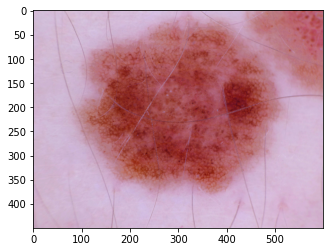

(450, 600, 3)


In [ ]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

In [17]:
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}

df_labels = pd.read_csv("ISIC2018GroundTruth.csv")
for i in range(len(df_labels)):
    labels = df_labels.iloc[i,1:]
    df_labels.loc[i,"label"] = mapping[list(labels).index(1)]

#df_labels["label"]=df_labels["label"].astype(int)
df_labels.set_index('image', inplace=True)

df_labels.head()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
image,,,,,,,,
ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


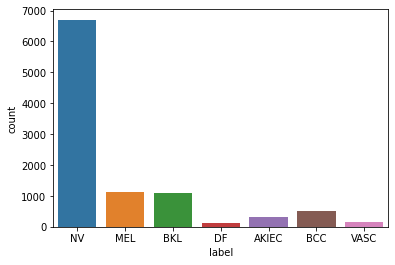

In [18]:
sns.countplot(df_labels["label"])
plt.show()

In [19]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'],
                                                  y=df_labels["label"])
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [ ]:
from tqdm import tqdm

images = os.listdir('HAM_images')

for image in tqdm(images):
    fname=image[:-4]
    label=df_labels.loc[fname, "label"]
    src = os.path.join('HAM_images', image)
    dst = os.path.join('HAM_Dataset', label, image)
    shutil.copyfile(src, dst)

100%|██████████| 10015/10015 [00:39<00:00, 253.53it/s]


### Train Test Split

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)

In [22]:
data_dir = 'HAM_Dataset'
batch_size = 32
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


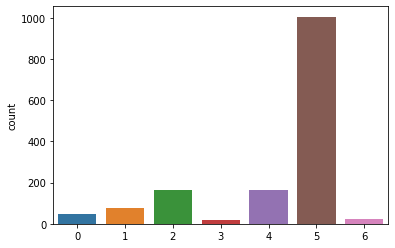

In [7]:
sns.countplot(x=test_image_gen.classes)

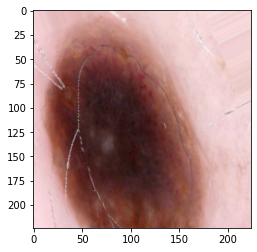

In [9]:
plt.imshow(train_image_gen[0][0][0]/255)

##     

## Transfer Learning using EfficientNetB4 Model

In [1]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)


tl_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_3[0][0]            
___________________________________________________________________________________________

In [13]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

### Model Training

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [3]:
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)


Epoch 7/20
267/267 [==============================] - 426s 2s/step - loss: 5.5603 - accuracy: 0.3382 - val_loss: 4.7682 - val_accuracy: 0.6318

Epoch 00001: val_accuracy improved from -inf to 0.63175, saving model to best_model_dn121.hdf5
Epoch 8/20
267/267 [==============================] - 415s 2s/step - loss: 4.2089 - accuracy: 0.6299 - val_loss: 3.7747 - val_accuracy: 0.7178

Epoch 00002: val_accuracy improved from 0.63175 to 0.71781, saving model to best_model_dn121.hdf5
Epoch 9/20
267/267 [==============================] - 417s 2s/step - loss: 3.3291 - accuracy: 0.6970 - val_loss: 3.0939 - val_accuracy: 0.7432

Epoch 00003: val_accuracy improved from 0.71781 to 0.74316, saving model to best_model_dn121.hdf5
Epoch 10/20
267/267 [==============================] - 415s 2s/step - loss: 2.6375 - accuracy: 0.7395 - val_loss: 2.5026 - val_accuracy: 0.7845

Epoch 00004: val_accuracy improved from 0.74316 to 0.78452, saving model to best_model_dn121.hdf5
Epoch 11/20
267/267 [============

### Model Evaluation

In [ ]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist.csv')

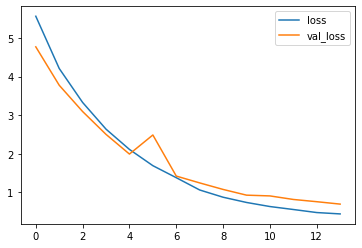

In [24]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

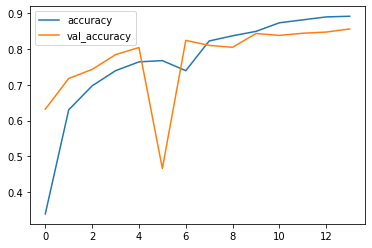

In [25]:
metrics[["accuracy","val_accuracy"]].plot()

In [38]:
tl_model.evaluate(test_image_gen)

47/47 [==============================] - 33s 701ms/step - loss: 0.6979 - accuracy: 0.8659


[0.6978632807731628, 0.8659105896949768]

In [27]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

47/47 [==============================] - 32s 612ms/step


In [28]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

Normalized confusion matrix
[[0.83673469 0.02040816 0.08163265 0.02040816 0.04081633 0.
  0.        ]
 [0.02597403 0.85714286 0.05194805 0.02597403 0.01298701 0.02597403
  0.        ]
 [0.05487805 0.01219512 0.82926829 0.00609756 0.02439024 0.07317073
  0.        ]
 [0.11764706 0.         0.         0.88235294 0.         0.
  0.        ]
 [0.01807229 0.02409639 0.14457831 0.         0.57228916 0.22289157
  0.01807229]
 [0.0039801  0.00597015 0.03681592 0.00895522 0.02985075 0.91144279
  0.00298507]
 [0.         0.         0.04761905 0.         0.         0.
  0.95238095]]


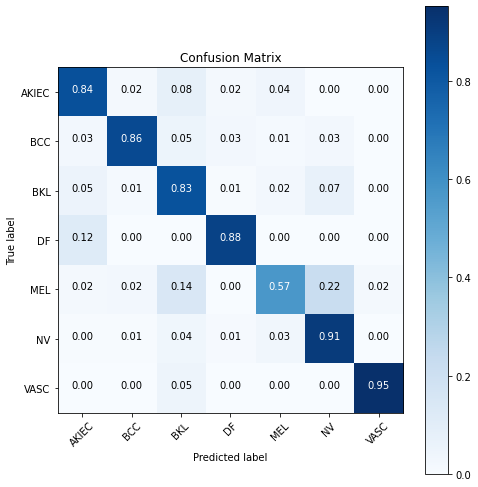

In [36]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [37]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.67      0.84      0.75        49
           1       0.84      0.86      0.85        77
           2       0.66      0.83      0.74       164
           3       0.54      0.88      0.67        17
           4       0.72      0.57      0.64       166
           5       0.95      0.91      0.93      1005
           6       0.77      0.95      0.85        21

    accuracy                           0.86      1499
   macro avg       0.73      0.83      0.77      1499
weighted avg       0.87      0.86      0.86      1499

